In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

Usando: cuda


In [3]:
raw_transform = transforms.Compose([
    transforms.ToTensor()
])

#Dataset
trainset_raw = datasets.CIFAR100(root='./data', train=True, download=True, transform=raw_transform)
loader = DataLoader(trainset_raw, batch_size=50000, shuffle=False)

data = next(iter(loader))[0]# Tomar los datos

# Calcular por canal
mean = data.mean(dim=(0, 2, 3))
std = data.std(dim=(0, 2, 3))

print("Media por canal:", mean)
print("Desviación estándar por canal:", std)


Media por canal: tensor([0.5071, 0.4866, 0.4409])
Desviación estándar por canal: tensor([0.2673, 0.2564, 0.2762])


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes
superclasses = trainset.class_to_idx  # Relación de clases


ResNet

In [5]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)  # Capa de salida de 100 clases

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shado\tf-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
def mostrar_prediccion(modelo, dataloader, classes):
    modelo.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = modelo(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(5):
            img = images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5
            plt.imshow(img)
            plt.title(f"Real: {classes[labels[i]]} - Predicho: {classes[predicted[i]]}")
            plt.axis('off')
            plt.show()


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0
patience = 5
trigger_times = 0

train_losses = []
train_accuracies = []

for epoch in range(30):  # Número de épocas
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_accuracies.append(acc)

    print(f"Época {epoch+1}, Precisión: {acc*100:.2f}%")

    # Pa Early stopping y checkpoint
    if acc > best_acc:
        best_acc = acc
        trigger_times = 0
        torch.save(model.state_dict(), "mejor_modelo.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activado")
            break



Época 1, Precisión: 23.75%
Época 2, Precisión: 31.75%
Época 3, Precisión: 38.42%
Época 4, Precisión: 40.47%
Época 5, Precisión: 41.91%
Época 6, Precisión: 45.04%
Época 7, Precisión: 45.94%
Época 8, Precisión: 45.63%
Época 9, Precisión: 43.58%
Época 10, Precisión: 43.93%
Época 11, Precisión: 45.34%
Época 12, Precisión: 44.22%
Early stopping activado


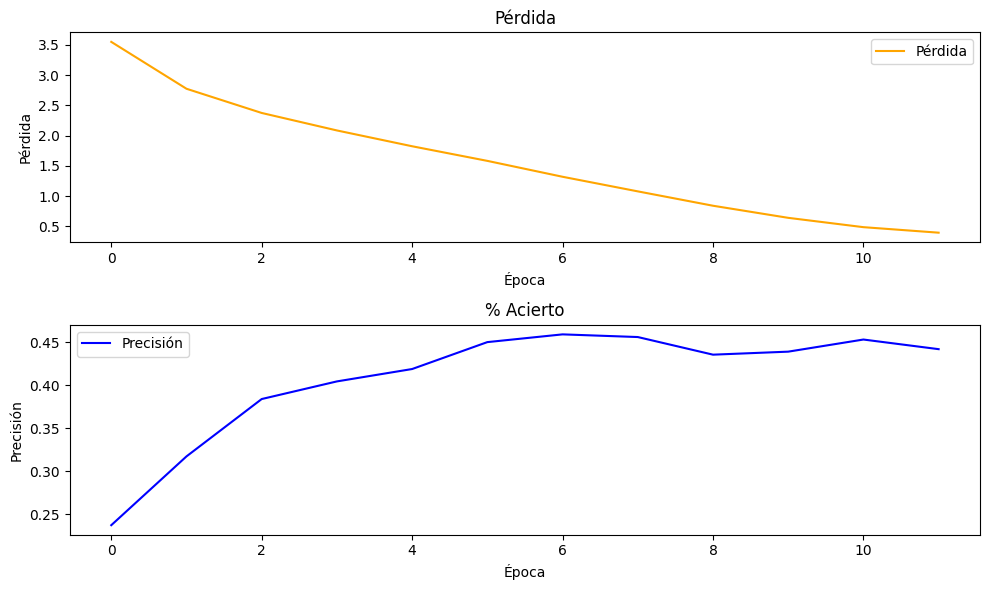

In [8]:
# Gráfico de pérdida y precisión por época
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(train_losses, label="Pérdida", color='orange')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_accuracies, label="Precisión", color='blue')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("% Acierto")
plt.legend()

plt.tight_layout()
plt.show()


MLP

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)  # 100 clases CIFAR-100

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp_model = MLP().to(device)


In [10]:
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

best_acc_mlp = 0.0
patience = 5
trigger_times = 0

mlp_losses = []
mlp_accuracies = []

for epoch in range(30):  # Número de épocas
    mlp_model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_mlp.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion_mlp(outputs, labels)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    mlp_losses.append(avg_loss)

    # Evaluación
    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    mlp_accuracies.append(acc)
    print(f"[MLP] Época {epoch+1}, Precisión: {acc*100:.2f}%")

    if acc > best_acc_mlp:
        best_acc_mlp = acc
        trigger_times = 0
        torch.save(mlp_model.state_dict(), "mejor_modelo_mlp.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activado (MLP)")
            break


[MLP] Época 1, Precisión: 16.92%
[MLP] Época 2, Precisión: 19.29%
[MLP] Época 3, Precisión: 19.64%
[MLP] Época 4, Precisión: 21.09%
[MLP] Época 5, Precisión: 21.35%
[MLP] Época 6, Precisión: 21.46%
[MLP] Época 7, Precisión: 21.85%
[MLP] Época 8, Precisión: 21.95%
[MLP] Época 9, Precisión: 22.50%
[MLP] Época 10, Precisión: 21.67%
[MLP] Época 11, Precisión: 22.04%
[MLP] Época 12, Precisión: 21.35%
[MLP] Época 13, Precisión: 22.13%
[MLP] Época 14, Precisión: 21.84%
Early stopping activado (MLP)


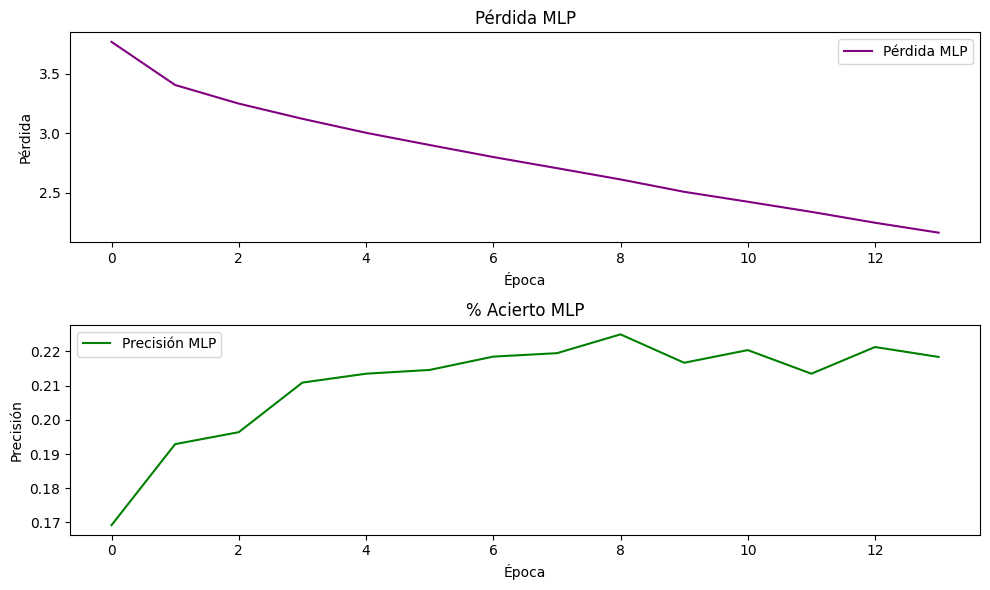

In [11]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(mlp_losses, label="Pérdida MLP", color='purple')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida MLP")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(mlp_accuracies, label="Precisión MLP", color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("% Acierto MLP")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
def evaluar_modelo(modelo, path_pesos, nombre="Modelo"):
    modelo.load_state_dict(torch.load(path_pesos))
    modelo.to(device)
    modelo.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = modelo(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n🔍 Resultados para {nombre}")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")
    print(f"Precision macro: {precision_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"Recall macro: {recall_score(all_labels, all_preds, average='macro'):.4f}")
    print(f"F1-score macro: {f1_score(all_labels, all_preds, average='macro'):.4f}")
    print("\nResumen por clase:")
    print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))

# Evaluar ResNet
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 100)
evaluar_modelo(resnet_model, "mejor_modelo.pth", nombre="ResNet")

# Evaluar MLP
mlp_model_eval = MLP()
evaluar_modelo(mlp_model_eval, "mejor_modelo_mlp.pth", nombre="MLP")



🔍 Resultados para ResNet
Accuracy: 45.94%
Precision macro: 0.4772
Recall macro: 0.4594
F1-score macro: 0.4580

Resumen por clase:
               precision    recall  f1-score   support

        apple       0.73      0.74      0.74       100
aquarium_fish       0.44      0.61      0.51       100
         baby       0.27      0.37      0.31       100
         bear       0.41      0.20      0.27       100
       beaver       0.35      0.19      0.25       100
          bed       0.49      0.45      0.47       100
          bee       0.46      0.54      0.50       100
       beetle       0.61      0.44      0.51       100
      bicycle       0.53      0.67      0.59       100
       bottle       0.66      0.60      0.63       100
         bowl       0.31      0.37      0.33       100
          boy       0.36      0.29      0.32       100
       bridge       0.51      0.44      0.47       100
          bus       0.41      0.42      0.41       100
    butterfly       0.53      0.35      0.4